## Задание на лабораторную работу.  
1. Модифицировать программный код лабораторной No3 с добавлением сохранения модели и сохранения сводных статистик для визуализации Tensorboard.  
2. Написать дополнительный код, который покажет демонстрацию восстановления модели из файла с расширением .ckpt.

## Исходный код ЛР

In [22]:
import tensorflow as tf
import os
tf.__version__

'2.1.0'

Использование GPU, если возможно

In [57]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
else:
    print("NO GPU")

NO GPU


Загрузка датасета MNIST

In [25]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.reshape(-1, 28*28) / 255.0, x_test.reshape(-1, 28*28) / 255.0

Функция, которая создает модель для обучения

In [26]:
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [27]:
model = create_model()
model.summary() #Архитектура модели

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


### Создание контрольной точки

In [28]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Создаем коллбек, сохраняющий веса модели
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Обучаем модель
model.fit(x_train, y_train, 
          epochs=5,
          validation_data=(x_test,y_test),
          callbacks=[cp_callback])  # Pass callback to training

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
59648/60000 [============================>.] - ETA: 0s - loss: 0.2209 - accuracy: 0.9350
Epoch 00001: saving model to training_1/cp.ckpt
60000/60000 [==============================] - 5s 82us/sample - loss: 0.2202 - accuracy: 0.9352 - val_loss: 0.1290 - val_accuracy: 0.9605
Epoch 2/5
59712/60000 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.9705
Epoch 00002: saving model to training_1/cp.ckpt
60000/60000 [==============================] - 5s 75us/sample - loss: 0.0975 - accuracy: 0.9705 - val_loss: 0.0790 - val_accuracy: 0.9749
Epoch 3/5
59488/60000 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9776
Epoch 00003: saving model to training_1/cp.ckpt
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0702 - accuracy: 0.9775 - val_loss: 0.0746 - val_accuracy: 0.9767
Epoch 4/5
59296/60000 [============================>.] - ETA: 0s - loss: 0.0544 - accuracy: 0.9

In [29]:
!ls {checkpoint_dir}

checkpoint                  cp.ckpt.index
cp.ckpt.data-00000-of-00001


### Восстановление модели

In [33]:
model = create_model()

loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print("Точность невостановленной модели: {:5.2f}%".format(100*accuracy))

10000/10000 - 0s - loss: 2.3813 - accuracy: 0.1560
Точность невостановленной модели: 15.60%


### Загрузка весов из сохранения

In [35]:
model.load_weights(checkpoint_path)

loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print("Точность востановленной модели: {:5.2f}%".format(100*accuracy))

10000/10000 - 0s - loss: 0.0675 - accuracy: 0.9797
Точность востановленной модели: 97.97%


### Сохранение всей модели в HDF5

In [42]:
model = create_model()

# Обучим модель
model.fit(x_train, y_train, epochs=5)

# Сохраним всю модель в  HDF5 файл
model.save('my_model.h5')

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 75us/sample - loss: 0.2168 - accuracy: 0.9359
Epoch 2/5
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0958 - accuracy: 0.9708
Epoch 3/5
60000/60000 [==============================] - 4s 73us/sample - loss: 0.0676 - accuracy: 0.9788
Epoch 4/5
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0553 - accuracy: 0.9821
Epoch 5/5
60000/60000 [==============================] - 4s 73us/sample - loss: 0.0437 - accuracy: 0.9857


### Восстановление всей модели

In [44]:
new_model = tf.keras.models.load_model('my_model.h5')
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [45]:
loss, acc = new_model.evaluate(x_test,  y_test, verbose=2)
print("Точность восстановленной модели: {:5.2f}%".format(100*acc))

10000/10000 - 0s - loss: 0.0715 - accuracy: 0.9785
Точность восстановленной модели: 97.85%


## Tensorboard

In [38]:
%load_ext tensorboard
!rm -rf ./logs/
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
board_model = create_model()

In [40]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 85us/sample - loss: 0.0366 - accuracy: 0.9882 - val_loss: 0.0689 - val_accuracy: 0.9803
Epoch 2/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0310 - accuracy: 0.9894 - val_loss: 0.0627 - val_accuracy: 0.9834
Epoch 3/5
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0271 - accuracy: 0.9907 - val_loss: 0.0658 - val_accuracy: 0.9819
Epoch 4/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0253 - accuracy: 0.9917 - val_loss: 0.0743 - val_accuracy: 0.9824
Epoch 5/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0239 - accuracy: 0.9917 - val_loss: 0.0776 - val_accuracy: 0.9822


In [41]:
%tensorboard --logdir logs/fit

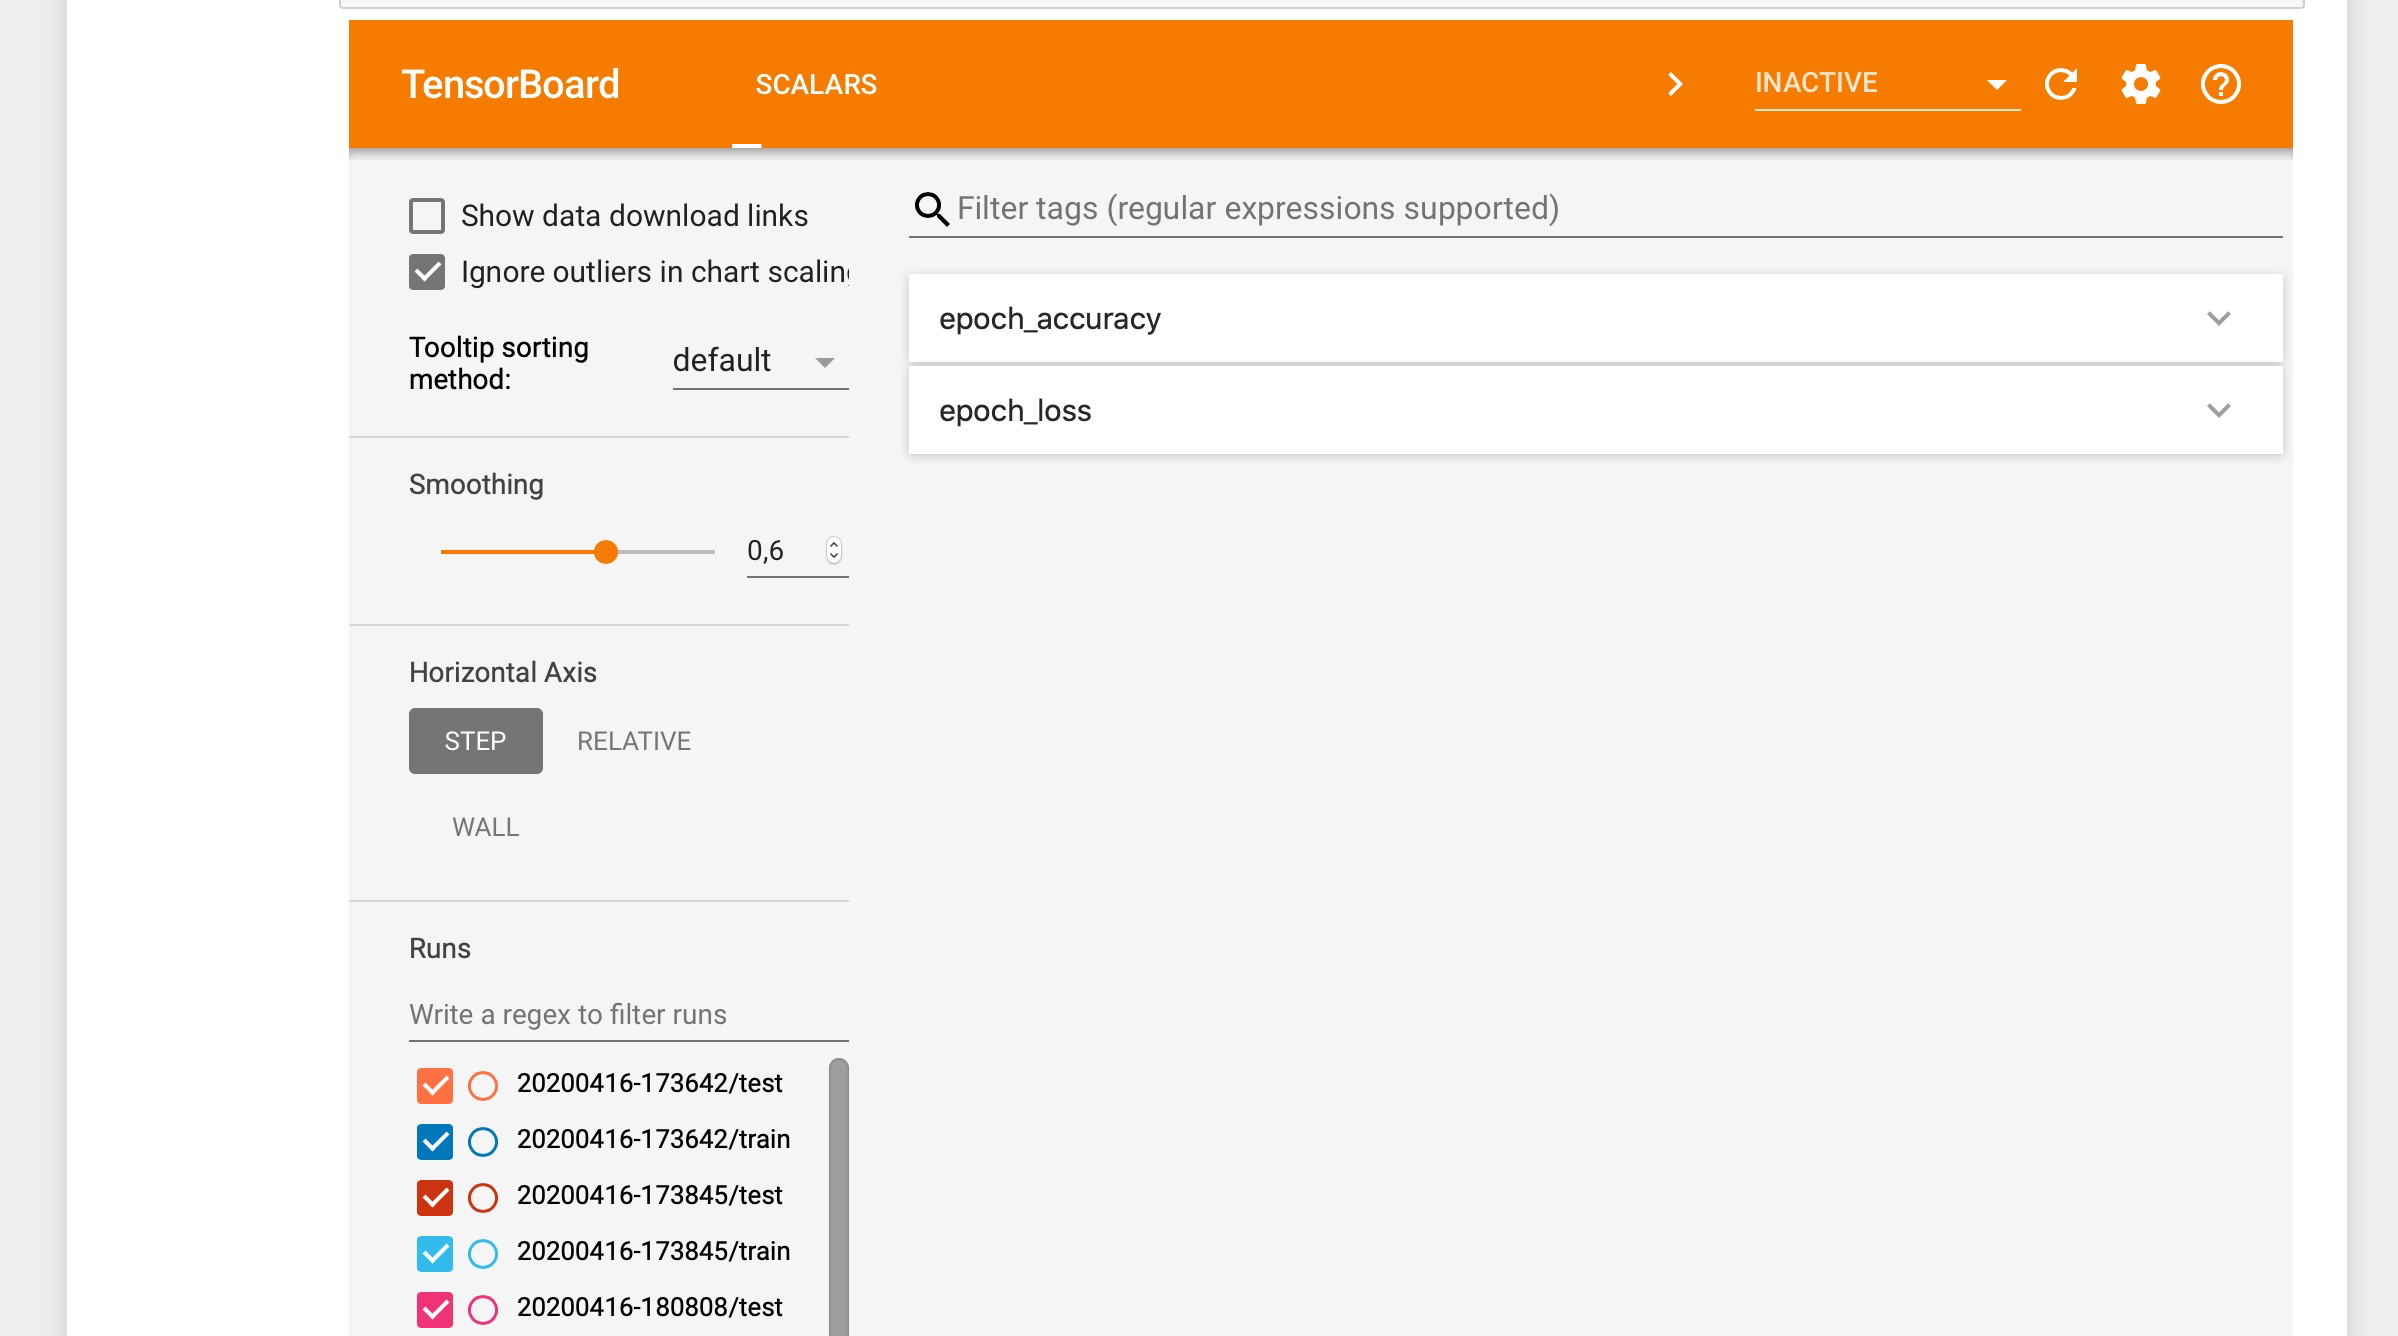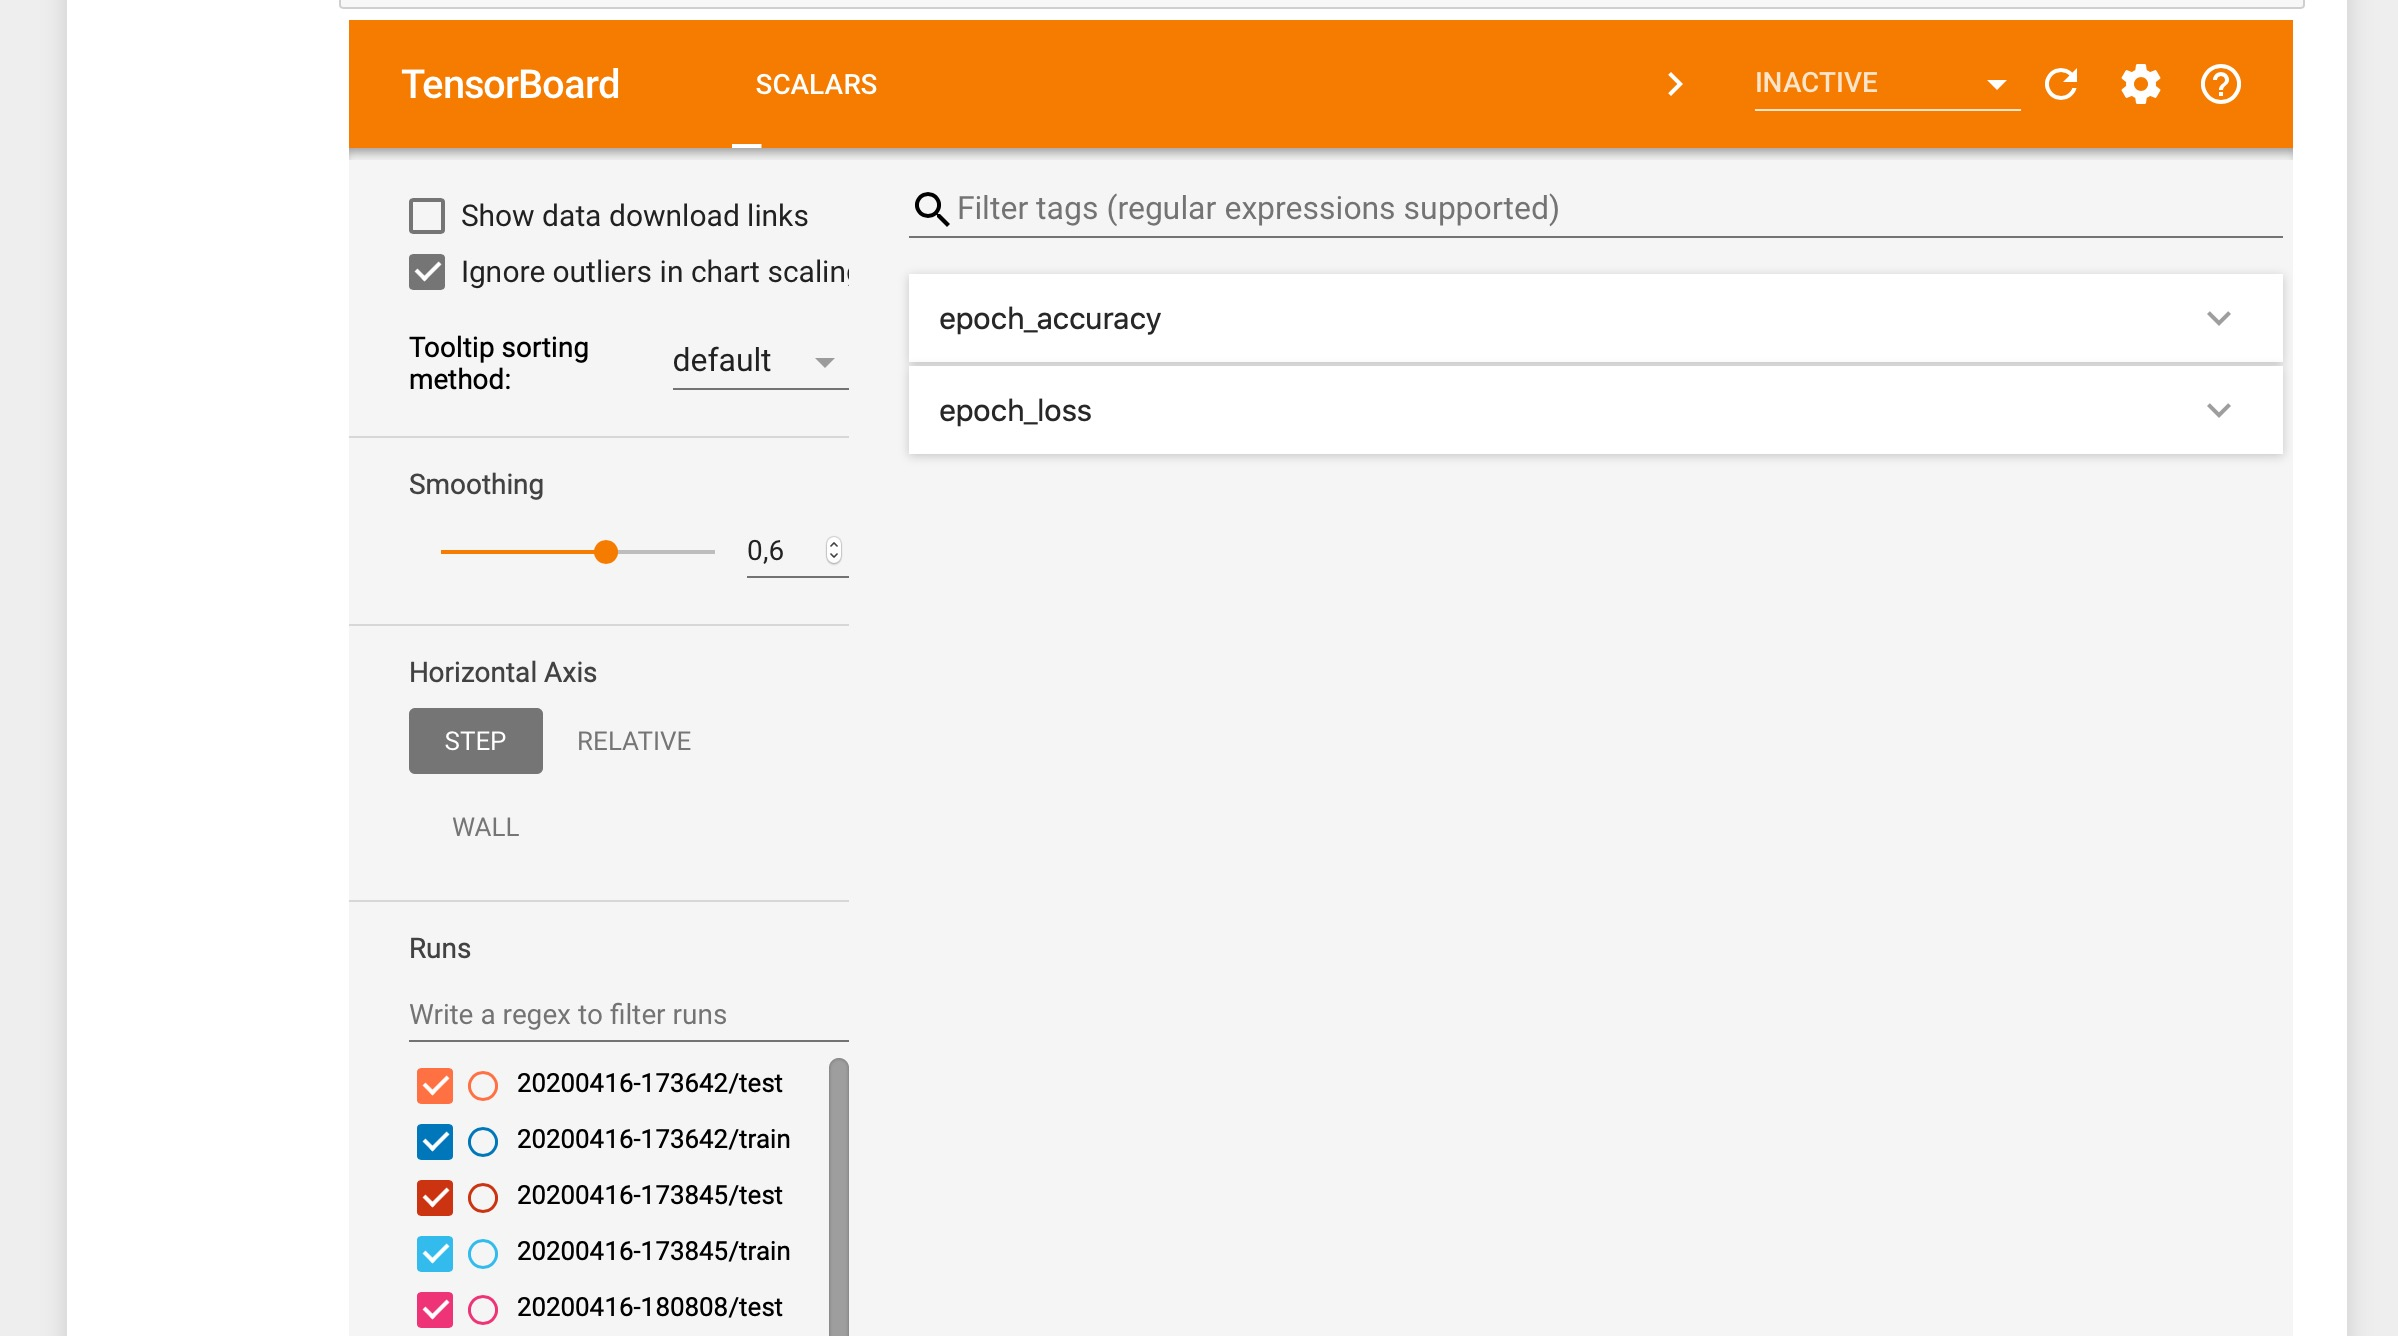

### Сохранение других метрик

In [50]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(60000).batch(64)
test_dataset = test_dataset.batch(64)

In [51]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [72]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')
cross_entropy = tf.keras.metrics.SparseCategoricalCrossentropy('cross_entropy')

In [79]:
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y_train, predictions)
    cross_entropy(y_train, predictions)


def test_step(model, x_test, y_test):
    predictions = model(x_test)
    loss = loss_object(y_test, predictions)
    
    test_loss(loss)
    test_accuracy(y_test, predictions)
    cross_entropy(y_test, predictions)

In [80]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [81]:
model = create_model()

EPOCHS = 5

for epoch in range(EPOCHS):
  for (x_train, y_train) in train_dataset:
    train_step(model, optimizer, x_train, y_train)
  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
    tf.summary.scalar('cross_entropy', cross_entropy.result(), step=epoch)

  for (x_test, y_test) in test_dataset:
    test_step(model, x_test, y_test)
  with test_summary_writer.as_default():
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
    tf.summary.scalar('cross_entropy', cross_entropy.result(), step=epoch)
  
  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(), 
                         train_accuracy.result()*100,
                         test_loss.result(), 
                         test_accuracy.result()*100))

  # Reset metrics every epoch
  train_loss.reset_states()
  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.18873284757137299, Accuracy: 94.28609466552734, Test Loss: 0.09651418775320053, Test Accuracy: 96.88999938964844
Epoch 2, Loss: 0.08392114192247391, Accuracy: 97.40833282470703, Test Loss: 0.07467450946569443, Test Accuracy: 97.64999389648438
Epoch 3, Loss: 0.059847474098205566, Accuracy: 98.14166259765625, Test Loss: 0.06194180250167847, Test Accuracy: 98.05999755859375
Epoch 4, Loss: 0.04545927047729492, Accuracy: 98.55166625976562, Test Loss: 0.056769710034132004, Test Accuracy: 98.1

In [82]:
%tensorboard --logdir logs/gradient_tape

Reusing TensorBoard on port 6006 (pid 11608), started 0:07:03 ago. (Use '!kill 11608' to kill it.)

file:///Users/admin/screenshots/Снимок%20экрана%202020-04-16%20в%2018.40.48.jpg

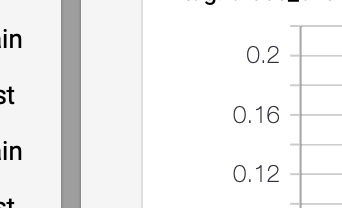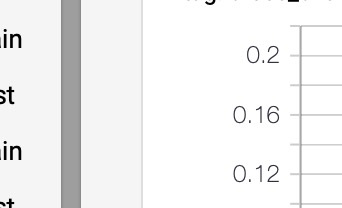

## Ответы на контрольные вопросы
1. TensorBoard входит в пакет tensorflow, Для загрузки надо указать %load_ext tensorboard, затем %tensorboard --logdir logs/gradient_tape для открытия самого tensorflow. Либо можно его открыть в отдельном окне с помощью tensorboard --logdir=PATH_TO_LOGS 

2. Используя команду tf.reset_default_graph() в tf1 или tf.keras.backend.clear_session() в tf2

3. Коллекция нужна для сохранения переменных узлов графа в tf1. 

4. Нужно объявить необходимые метрики, затем в шаге Вычислить их.   
Указать путь к папке с логами и использовать коллбек tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1), который затем указать при вызове model.fit(callback=[callback]).   
Для записи текущего значения воспользоваться tf.summary.create_file_writer()   
with train_summary_writer.as_default():   
    tf.summary.scalar('loss', train_loss.result(), step=epoch)   
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)   
    tf.summary.scalar('cross_entropy', cross_entropy.result(), step=epoch)   

## Список литературы
[1] Google. Tensorflow. 2018. Feb. url - https://www.tensorflow.org/install/install_windows.    
[2] url - https://virtualenv.pypa.io/en/stable/userguide/.    
[3] Microsoft. about_Execution_Policies. 2018. url - https://technet.microsoft.com/en- us/library/dd347641.aspx.   
[4] Jupyter Project. Installing Jupyter. 2018. url - http://jupyter.org/install.   